# Model Manager

This notebook shows how to:


1.   Train a NextStep-RNN on multiple time steps
2.   Use the ModelManager to make online predictions



In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = './logs/'

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# matplotlib rendering
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir -> for module loading

TensorFlow 2.x selected.


In [2]:
import os
import random
import itertools

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import backend as K
from datetime import datetime
from collections import defaultdict

# custom modules
import data
import model

print('Tensorflow version:', tf.__version__)

print('GPU support:', tf.test.is_gpu_available())
plt.rcParams['figure.figsize'] = [20, 10]

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# set all keras layers to use float64
tf.keras.backend.set_floatx('float64')

Tensorflow version: 2.0.0
GPU support: True


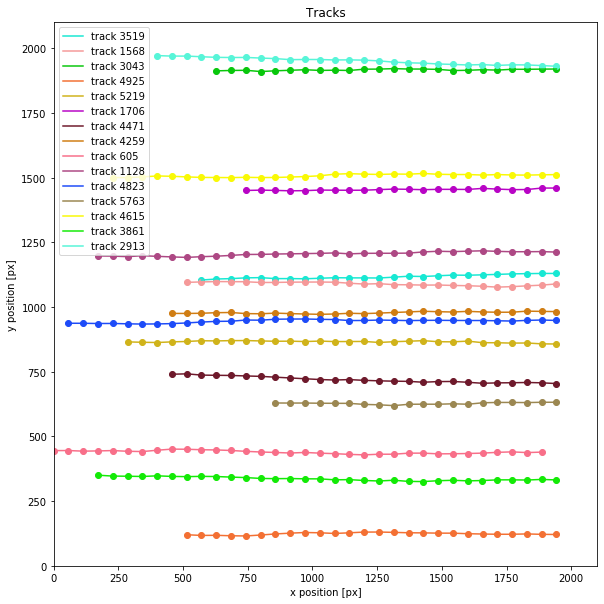

In [3]:
# Data loading
num_time_steps = 35
batch_size = 128
nan_value = 0
belt_width = 2000

fake_data_set = data.FakeDataSet(timesteps=num_time_steps, 
                                 batch_size=batch_size,
                                 number_trajectories=6000, 
                                 additive_noise_stddev=2, 
                                 additive_target_stddev=20,
                                 belt_width=belt_width)

# get tf.Dataset for sequential training
dataset_train, dataset_test = fake_data_set.get_tf_data_sets_seq2seq_data(normalized=True)

fake_data_set.plot_random_tracks(n=15)

In [0]:
# Train model

rnn_model, hash_ = model.rnn_model_factory(
        num_units_first_rnn=2, 
        num_units_second_rnn=0,
        num_units_first_dense=0,
        rnn_model_name='lstm',
        num_time_steps=num_time_steps, 
        batch_size=batch_size, 
        nan_value=nan_value, 
        # unroll=False,
        input_dim=2)
print(rnn_model.summary())

optimizer = tf.keras.optimizers.Adam()
train_step_fn = model.train_step_generator(rnn_model, optimizer)
calc_mae_test_fn = model.tf_error(rnn_model, dataset_test, belt_width, squared=False)

loss_history = []
total_num_epochs = 400

for epoch in range(total_num_epochs):
  # learning rate decay after 100 epochs
  if (epoch+1) % 150 == 0:
      old_lr = K.get_value(optimizer.lr)
      new_lr = old_lr * 0.1
      print("Reducing learning rate from {} to {}.".format(old_lr, new_lr))
      K.set_value(optimizer.lr, new_lr)

  for (batch_n, (inp, target)) in enumerate(dataset_train):
      _ = rnn_model.reset_states()
      loss = train_step_fn(inp, target)  
      loss_history.append(loss)

  print("{}/{}: \t loss={}".format(epoch, total_num_epochs, loss))

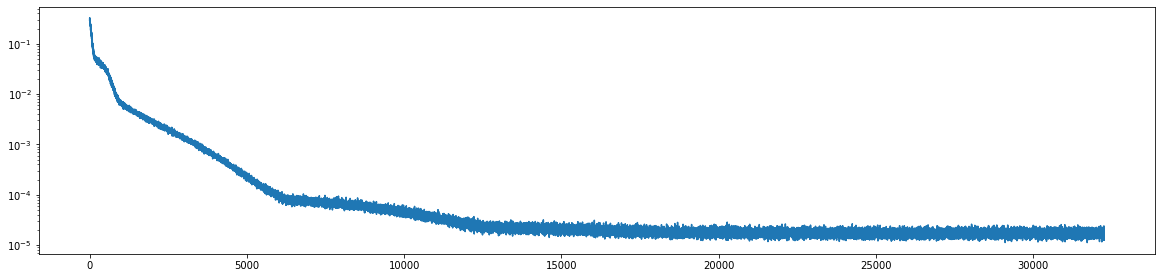

In [15]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.set_yscale('log')
plt.plot(loss_history)

In [16]:
# evaluate model with MAE
test_mae = calc_mae_test_fn()
print(test_mae.numpy())

9.290485914366636


## Model Manager

Now that the model is trained, we can give it to the ModelManager and make 
online predictions.

In [0]:
tracks = []
track_ids = []

number_tracks = 50
time_steps = 25

model_manager = model.ModelManager(number_tracks, 128, rnn_model)

# create a random start position for every track
for i in range(number_tracks):
  tracks.append([[random.random(), random.random()]])
  track_ids.append(model_manager.allocate_track())

In [0]:
# for every time step: make a prediction for every particle

for t in range(time_steps):

  # set the measurements for the tracks
  for i in range(number_tracks):
    old_pos = tracks[i][-1]
    model_manager.set_track_measurement(track_ids[i], np.array(old_pos))

  # predict all tracks
  predictions = model_manager.predict()

  # store the predictions
  for i in range(number_tracks):
    x = predictions[i][0]
    y = predictions[i][1]
    tracks[track_ids[i]].append([x, y])

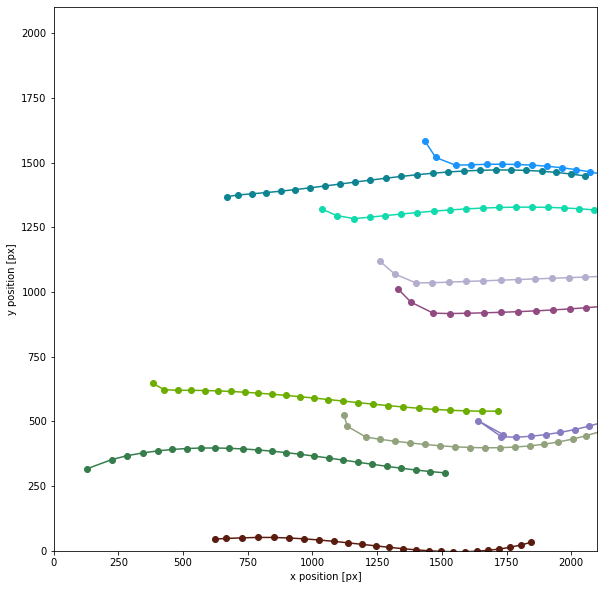

In [20]:
for i in range(10):
  track = (np.array(tracks[i]) * 2000.0).reshape(26, 2)
  fake_data_set.plot_track(track, color=np.random.rand(3), legend=False)